<a href="https://colab.research.google.com/github/ahsanashraf148/Applied-Data-Science-Capstone/blob/main/site/en/tutorials/generative/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 21k=3186
## Ahsan Ashraf
## Lab 8

# Deep Convolutional Generative Adversarial Network

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan1.png?raw=1)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1)

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

To learn more about GANs, see MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

### Setup

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.18.0'

In [3]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-w4y6db_a
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-w4y6db_a
  Resolved https://github.com/tensorflow/docs to commit a8576cef38b7182e6228d7aafca8ef51754ab9e8
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2025.3.6.10029-py3-none-any.whl size=186351 sha256=408d6f33993afd4b0e30661dc57f8c1ff23e447be4fd3ed8c1fed3f14b160a15
  Stored in directory: /tmp/pip-ephem-wheel-cache-asj5t3c6/wheels/34/53/89/3db54cf97ce0f0261aaab3fdc12a847ea0879d34edf373e2c5
Successfully built tensorflow-docs


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Use the (as yet untrained) generator to create an image.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


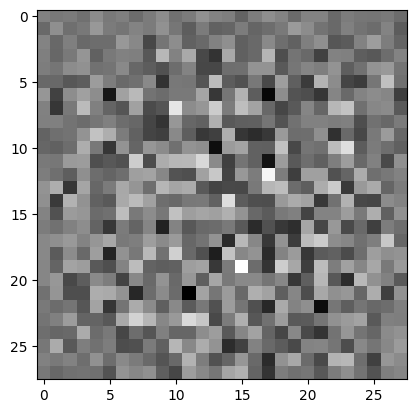

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.00137955]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [23]:
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [25]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [26]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

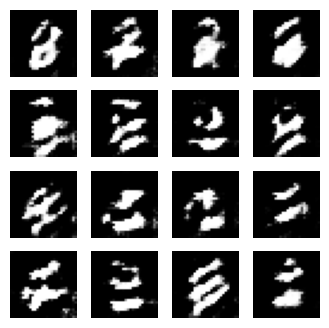

In [27]:
train(train_dataset, EPOCHS)

# Restore the latest checkpoint.

In [28]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [29]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

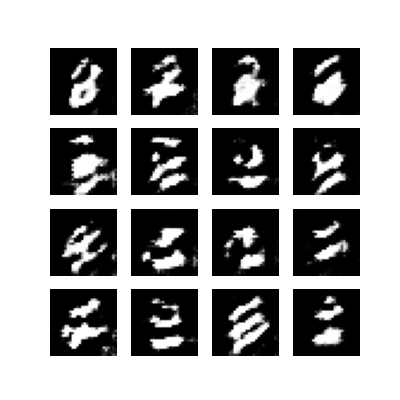

In [30]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [31]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-31-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-31-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



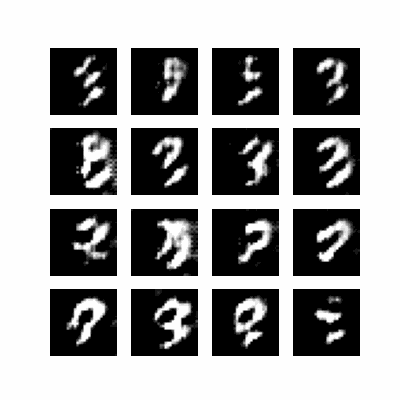

In [32]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [33]:
# 1. Visualize the latent space interpolation
def generate_interpolated_images(start_vector, end_vector, num_steps=10):
    """Generate images by interpolating between two noise vectors"""
    interpolated_vectors = []

    for step in range(num_steps):
        # Linear interpolation
        alpha = step / (num_steps - 1)
        interpolated_vector = start_vector * (1 - alpha) + end_vector * alpha
        interpolated_vectors.append(interpolated_vector)

    # Generate images from interpolated vectors
    interpolated_vectors = np.array(interpolated_vectors)
    interpolated_images = generator(interpolated_vectors, training=False)

    # Plot the images
    plt.figure(figsize=(20, 4))
    for i in range(num_steps):
        plt.subplot(1, num_steps, i+1)
        plt.imshow(interpolated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('interpolated_images.png')
    plt.show()

    return interpolated_images

# 2. Create a smoother GIF animation
def create_smooth_gif(filename='dcgan_smooth.gif', fps=15):
    """Create a smoother GIF by interpolating between epochs"""
    filenames = sorted(glob.glob('image_at_epoch*.png'))
    images = []

    for i in range(len(filenames)-1):
        # Read the two consecutive images
        img1 = imageio.imread(filenames[i])
        img2 = imageio.imread(filenames[i+1])

        # Add the first image
        images.append(img1)

        # Create 3 interpolated frames between each pair
        for j in range(1, 4):
            alpha = j / 4.0
            interp_img = (1-alpha) * img1 + alpha * img2
            images.append(interp_img.astype(np.uint8))

    # Add the last image
    images.append(imageio.imread(filenames[-1]))

    # Save the GIF
    with imageio.get_writer(filename, mode='I', fps=fps) as writer:
        for image in images:
            writer.append_data(image)

    print(f"Smooth GIF created: {filename}")
    return filename

# 3. Generate a grid of images from random noise
def generate_image_grid(rows=5, cols=5):
    """Generate a grid of images from random noise"""
    noise = tf.random.normal([rows * cols, noise_dim])
    generated_images = generator(noise, training=False)

    fig = plt.figure(figsize=(cols * 2, rows * 2))

    for i in range(rows * cols):
        plt.subplot(rows, cols, i+1)
        plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('generated_grid.png')
    plt.show()

    return generated_images

# 4. Visualize the discriminator's decision boundary
def visualize_discriminator_boundary(samples=1000):
    """Visualize how the discriminator classifies images"""
    # Generate random images
    noise = tf.random.normal([samples, noise_dim])
    generated_images = generator(noise, training=False)

    # Get discriminator predictions
    predictions = discriminator(generated_images, training=False)
    predictions = tf.squeeze(predictions).numpy()

    # Sort images by discriminator score
    sorted_indices = np.argsort(predictions)
    sorted_images = tf.gather(generated_images, sorted_indices)
    sorted_scores = tf.gather(predictions, sorted_indices)

    # Display a sample of images with their scores
    fig = plt.figure(figsize=(15, 8))

    # Show the most "fake" images according to discriminator
    plt.subplot(2, 3, 1)
    plt.title(f"Most 'Fake' (Score: {sorted_scores[0]:.4f})")
    plt.imshow(sorted_images[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.title(f"Very 'Fake' (Score: {sorted_scores[samples//10]:.4f})")
    plt.imshow(sorted_images[samples//10, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.title(f"Somewhat 'Fake' (Score: {sorted_scores[samples//4]:.4f})")
    plt.imshow(sorted_images[samples//4, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.title(f"Somewhat 'Real' (Score: {sorted_scores[samples//2]:.4f})")
    plt.imshow(sorted_images[samples//2, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.title(f"Very 'Real' (Score: {sorted_scores[-samples//10]:.4f})")
    plt.imshow(sorted_images[-samples//10, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.title(f"Most 'Real' (Score: {sorted_scores[-1]:.4f})")
    plt.imshow(sorted_images[-1, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('discriminator_boundary.png')
    plt.show()

    # Plot the distribution of scores
    plt.figure(figsize=(10, 5))
    plt.hist(predictions, bins=50, alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Distribution of Discriminator Scores')
    plt.xlabel('Score (negative = fake, positive = real)')
    plt.ylabel('Count')
    plt.savefig('discriminator_scores.png')
    plt.show()

# 5. Explore the latent space with vector arithmetic
def latent_space_arithmetic():
    """Demonstrate latent space arithmetic (similar to word2vec)"""
    # Generate multiple noise vectors
    n_samples = 10000
    noise = tf.random.normal([n_samples, noise_dim])
    images = generator(noise, training=False)

    # Find the vectors that produce the most distinct digits
    # This is a simple approach - in practice you'd want to use a classifier
    # to find the best examples of each digit

    # For simplicity, we'll just pick some random vectors
    selected_indices = np.random.choice(n_samples, size=6, replace=False)
    selected_noise = tf.gather(noise, selected_indices)
    selected_images = tf.gather(images, selected_indices)

    # Now perform some "arithmetic" in the latent space
    # For example: vec1 - vec2 + vec3
    result_noise = selected_noise[0] - selected_noise[1] + selected_noise[2]
    result_noise = tf.reshape(result_noise, [1, noise_dim])
    result_image = generator(result_noise, training=False)

    # Display the images and the result
    plt.figure(figsize=(15, 6))

    # Display the "equation" images
    for i in range(3):
        plt.subplot(2, 4, i+1)
        if i == 0:
            plt.title("Vec1")
        elif i == 1:
            plt.title("- Vec2")
        else:
            plt.title("+ Vec3")
        plt.imshow(selected_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # Display the result
    plt.subplot(2, 4, 4)
    plt.title("= Result")
    plt.imshow(result_image[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

    # Display more examples
    for i in range(3):
        plt.subplot(2, 4, i+5)
        plt.title(f"Example {i+4}")
        plt.imshow(selected_images[i+3, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('latent_arithmetic.png')
    plt.show()

# 6. Analyze training progress
def analyze_training_progress():
    """Analyze the quality of generated images over training epochs"""
    # Load images from different epochs
    image_files = sorted(glob.glob('image_at_epoch*.png'))

    # Select a subset of epochs to analyze
    selected_epochs = np.linspace(0, len(image_files)-1, 5).astype(int)
    selected_files = [image_files[i] for i in selected_epochs]

    plt.figure(figsize=(15, 6))

    for i, file in enumerate(selected_files):
        epoch = int(file.split('_')[-1].split('.')[0])
        img = imageio.imread(file)

        plt.subplot(1, len(selected_files), i+1)
        plt.title(f"Epoch {epoch}")
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('training_progress.png')
    plt.show()

# 7. Generate animated zoom into latent space
def generate_latent_zoom(steps=30):
    """Generate a zoom animation into latent space"""
    # Start with a random noise vector
    start_noise = tf.random.normal([1, noise_dim])

    # Create vectors that progressively zoom in
    zoom_vectors = []
    for i in range(steps):
        # Scale factor decreases as we zoom in
        scale = 1.0 - (0.9 * i / steps)
        zoomed_noise = start_noise * scale
        zoom_vectors.append(zoomed_noise)

    # Generate images from these vectors
    zoom_vectors = tf.concat(zoom_vectors, axis=0)
    zoom_images = generator(zoom_vectors, training=False)

    # Save images
    os.makedirs('zoom_frames', exist_ok=True)
    for i in range(steps):
        plt.figure(figsize=(4, 4))
        plt.imshow(zoom_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        plt.savefig(f'zoom_frames/zoom_{i:03d}.png')
        plt.close()

    # Create GIF
    with imageio.get_writer('latent_zoom.gif', mode='I', fps=10) as writer:
        for i in range(steps):
            image = imageio.imread(f'zoom_frames/zoom_{i:03d}.png')
            writer.append_data(image)

    print("Latent space zoom animation created as 'latent_zoom.gif'")

# 8. Generate images with progressive noise reduction
def generate_noise_reduction(steps=10):
    """Generate images with progressively reduced noise"""
    # Generate a base noise vector
    base_noise = tf.random.normal([1, noise_dim])

    # Create versions with progressively reduced noise
    noise_vectors = []
    for i in range(steps):
        # Add progressively smaller random perturbations
        noise_scale = 1.0 - (i / steps)
        random_noise = tf.random.normal([1, noise_dim]) * noise_scale
        noisy_vector = base_noise + random_noise
        noise_vectors.append(noisy_vector)

    # Generate images
    noise_vectors = tf.concat(noise_vectors, axis=0)
    noise_images = generator(noise_vectors, training=False)

    # Display images
    plt.figure(figsize=(20, 4))
    for i in range(steps):
        plt.subplot(1, steps, i+1)
        plt.title(f"Noise: {100*(1.0 - i/steps):.0f}%")
        plt.imshow(noise_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('noise_reduction.png')
    plt.show()

# Example of how to use these functions:
print("\nAdditional DCGAN analysis functions loaded!")
print("Run any of the following functions to enhance your DCGAN exploration:")
print("1. generate_interpolated_images(start_vector, end_vector)")
print("2. create_smooth_gif()")
print("3. generate_image_grid()")
print("4. visualize_discriminator_boundary()")
print("5. latent_space_arithmetic()")
print("6. analyze_training_progress()")
print("7. generate_latent_zoom()")
print("8. generate_noise_reduction()")

# Create two random vectors for interpolation
vector1 = tf.random.normal([1, noise_dim])
vector2 = tf.random.normal([1, noise_dim])




Additional DCGAN analysis functions loaded!
Run any of the following functions to enhance your DCGAN exploration:
1. generate_interpolated_images(start_vector, end_vector)
2. create_smooth_gif()
3. generate_image_grid()
4. visualize_discriminator_boundary()
5. latent_space_arithmetic()
6. analyze_training_progress()
7. generate_latent_zoom()
8. generate_noise_reduction()


In [37]:
create_smooth_gif()

<ipython-input-33-16467a24c174>:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(filenames[i])
<ipython-input-33-16467a24c174>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(filenames[i+1])
<ipython-input-33-16467a24c174>:50: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filenames[-1]))


Smooth GIF created: dcgan_smooth.gif


'dcgan_smooth.gif'

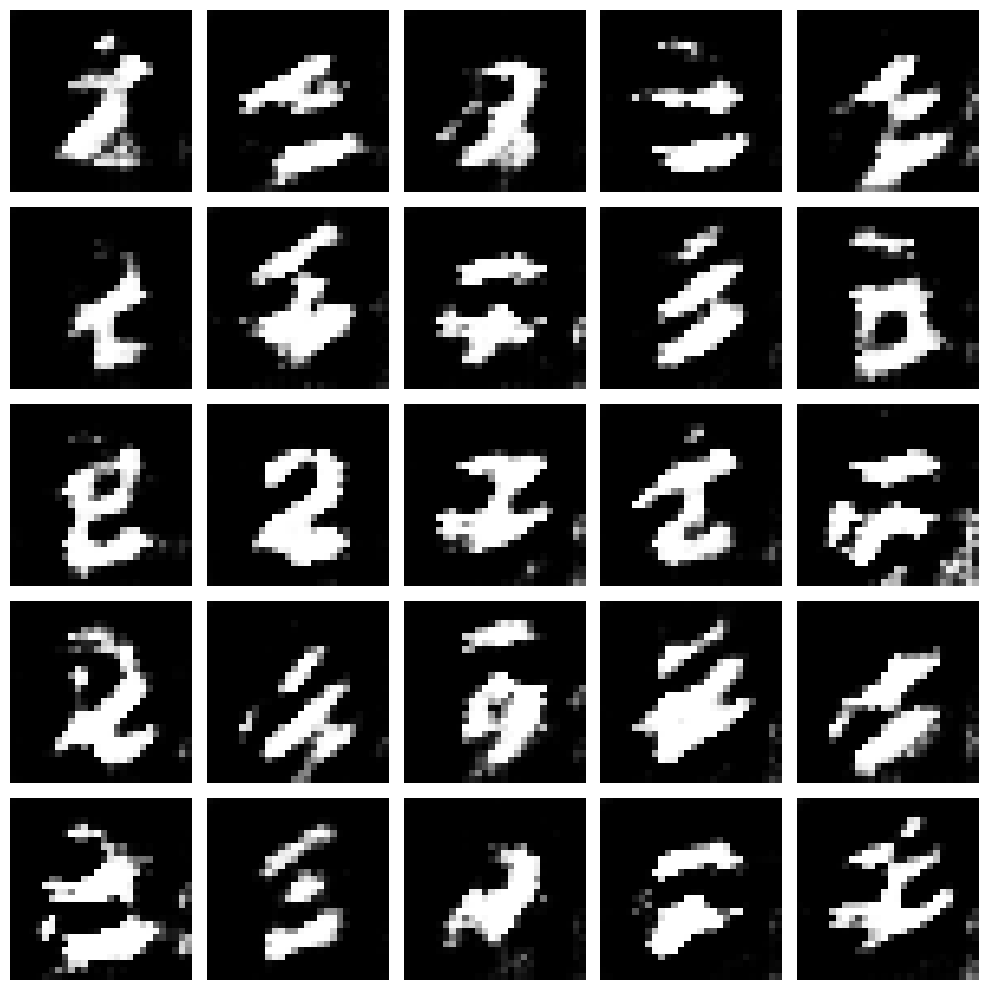

<tf.Tensor: shape=(25, 28, 28, 1), dtype=float32, numpy=
array([[[[-0.96876943],
         [-0.9902941 ],
         [-0.99978274],
         ...,
         [-0.99933165],
         [-0.9972132 ],
         [-0.99606615]],

        [[-0.9910761 ],
         [-0.9987613 ],
         [-0.9999874 ],
         ...,
         [-0.99997973],
         [-0.99988794],
         [-0.9989537 ]],

        [[-0.997981  ],
         [-0.999805  ],
         [-0.9999971 ],
         ...,
         [-0.9999995 ],
         [-0.9999586 ],
         [-0.99996465]],

        ...,

        [[-0.99843943],
         [-0.9997858 ],
         [-0.9999962 ],
         ...,
         [-0.9999797 ],
         [-0.999063  ],
         [-0.99703443]],

        [[-0.99524707],
         [-0.9990029 ],
         [-0.9999788 ],
         ...,
         [-0.9995695 ],
         [-0.99947166],
         [-0.9984976 ]],

        [[-0.990312  ],
         [-0.9945263 ],
         [-0.9998262 ],
         ...,
         [-0.99845463],
         [-0.993257

In [38]:
generate_image_grid()

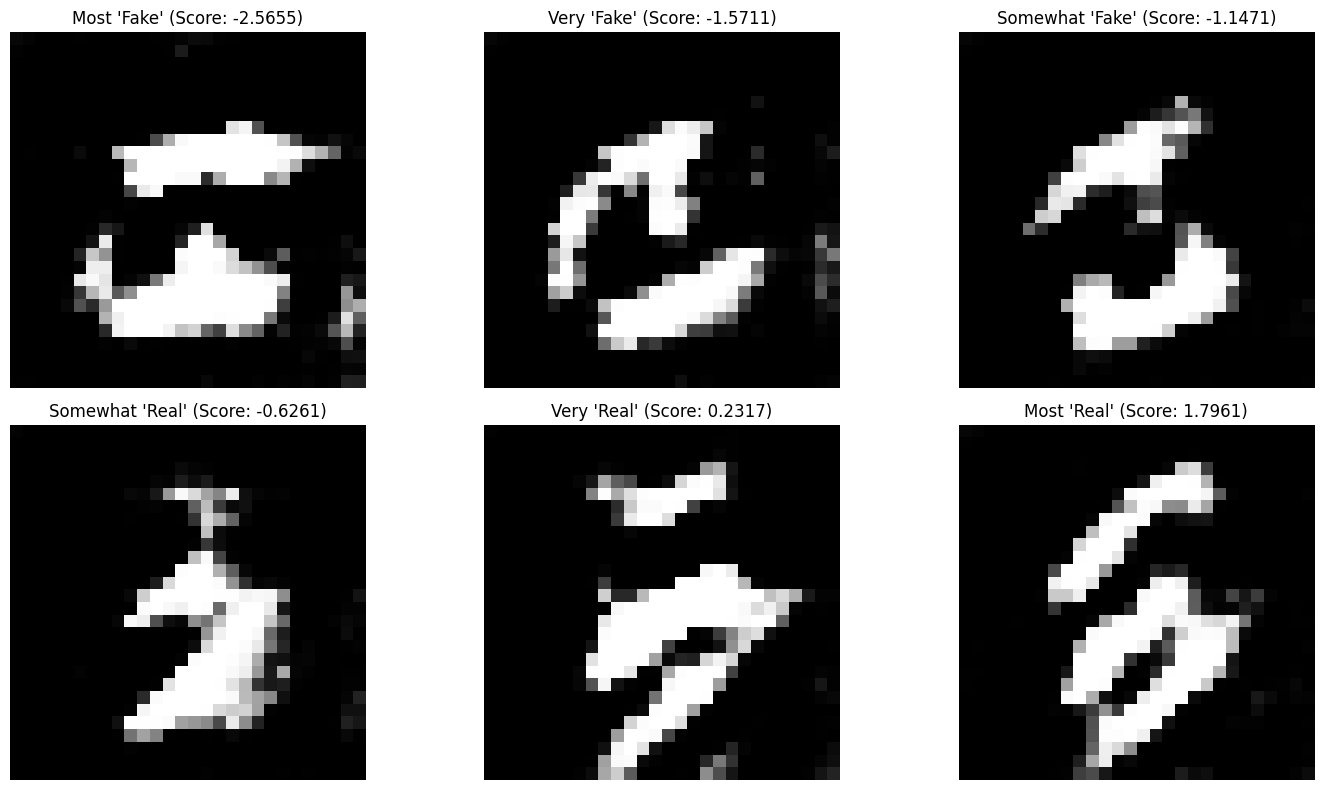

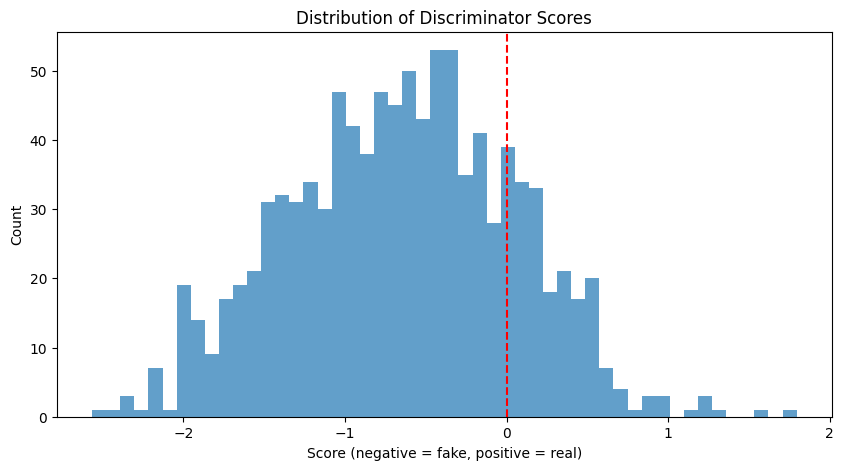

In [39]:
visualize_discriminator_boundary()

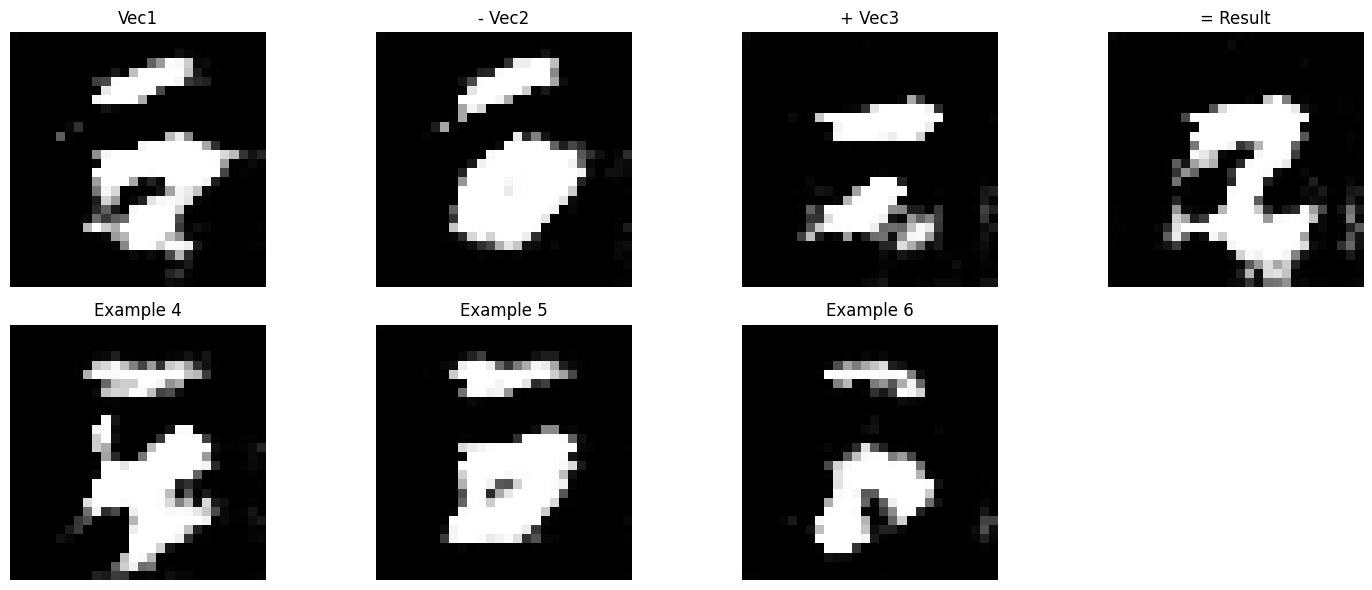

In [40]:
latent_space_arithmetic()

<ipython-input-33-16467a24c174>:212: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(file)


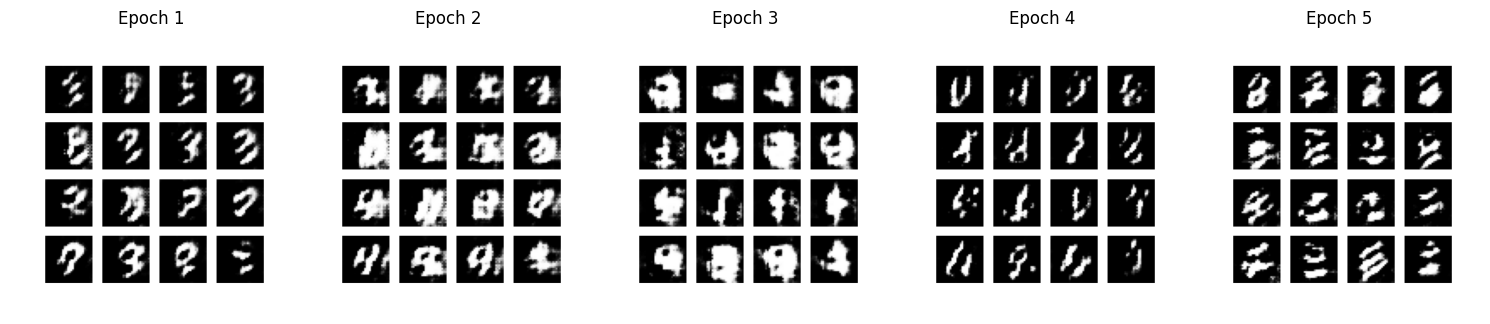

In [41]:
analyze_training_progress()

In [42]:
generate_latent_zoom()

<ipython-input-33-16467a24c174>:253: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(f'zoom_frames/zoom_{i:03d}.png')


Latent space zoom animation created as 'latent_zoom.gif'


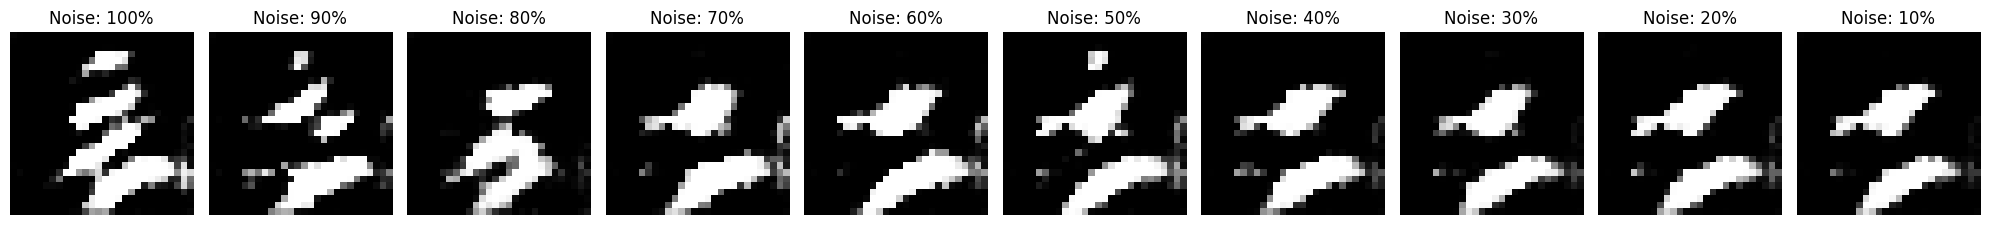

In [43]:
generate_noise_reduction()